# Deep Deterministic Policy Gradient

En este notebook se implementará el algoritmo DDPG y se aplicará a un ambiente de gymnasium.

Primero se importarán las bibliotecas necesarias.

In [ ]:
!pip install gym[mujoco]

In [ ]:
!pip install glfw

In [ ]:
!pip install mujoco

In [ ]:
try:
    import ptan
except:
    !pip install ptan
    import ptan

In [ ]:
try:
    from tensorboardX import SummaryWriter
except:
    !pip install tensorboardX
    from tensorboardX import SummaryWriter

In [ ]:
import argparse
import time
import numpy as np
import collections
import gym
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

## La biblioteca PTAN

Para simplificar la implementación, se usará la biblioteca PTAN (Pytorch AgentNet), la cual es una caja de herramientas de aprendizaje por refuerzo.

Para esta implementación se usará la plantilla para el agente `BaseAgent`. Para el buffer de recuerdos se usará la clase `ExperienceReplayBuffer`.

## El actor

Se creará la clase para la red neuronal relacionada con la política, a la cual se le llama *actor*.

In [ ]:
class Actor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Actor, self).__init__()

        self.net = nn.Sequential(
            #nn.BatchNorm1d(obs_size),
            nn.Linear(obs_size, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, act_size),
            nn.Tanh())

    def forward(self, x):
        # en el caso de cartpole de Mujoco, la señal está en el rango [-3,3]
        # por eso se multiplica el resultado de tanh por 3
        return 3*self.net(x)

## El crítico

Ahora se creará la clase para la red neuronal relacionada con la función de acción-valor ($Q(s, a)$).

Las acciones no se incluyen hasta la segunda capa de $Q$.

In [ ]:
class Critic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Critic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, 400),
            nn.ReLU())

        self.out_net = nn.Sequential(
            nn.Linear(400 + act_size, 300),
            nn.ReLU(),
            nn.Linear(300, 1))

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))

## El agente

Ahora se creará la clase para el agente de aprendizaje por refuerzo.

Para la exploración se usa ruido correlacionado. Se usa el proceso de *Ornstein-Uhlenbeck* con $\theta = 0.15$ y $\sigma = 0.2$, con una media de 0.

In [ ]:
class Agent(ptan.agent.BaseAgent):
    def __init__(self, net, device='cpu', ou_enabled=True, ou_mu=0.0, ou_teta=0.15, ou_sigma=0.2, ou_epsilon=1.0):
        self.net = net
        self.device = device
        self.ou_enabled = ou_enabled
        self.ou_mu = ou_mu
        self.ou_teta = ou_teta
        self.ou_sigma = ou_sigma
        self.ou_epsilon = ou_epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()

        if self.ou_enabled and self.ou_epsilon > 0:
            new_a_states = []
            for a_state, action in zip(agent_states, actions):
                if a_state is None:
                    a_state = np.zeros(shape=action.shape, dtype=np.float32)
                a_state += self.ou_teta*(self.ou_mu - a_state)
                a_state += self.ou_sigma*np.random.normal(size=action.shape)
                action += self.ou_epsilon*a_state
                new_a_states.append(a_state)
        else:
            new_a_states = agent_states
        actions = np.clip(actions, -1, 1)
        return actions, new_a_states

## Preprocesamiento del lote

Se usará una función para desempacar el lote.

In [ ]:
def unpack_batch(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v

## Fase de entrenamiento

Primero se definirán los parámetros para la fase de entrenamiento.

In [ ]:
#ENV_ID = 'Pendulum-v1'
ENV_ID = 'InvertedPendulum-v4'
GAMMA = 0.99
BATCH_SIZE = 64
LEARNING_RATE_ACTOR = 1e-4
LEARNING_RATE_CRITIC = 1e-3
REPLAY_SIZE = 100000
REPLAY_INITIAL = 1000
TEST_ITERS = 1000
MAX_EPOCAS = 100000 # cambiar dependiendo del tiempo que tarda

In [ ]:
def test_net(net, env, count=10, device='cpu'):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        terminado = False
        while not terminado:
            obs_v = ptan.agent.float32_preprocessor([obs]).to(device)
            mu_v = net(obs_v)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            action = np.clip(action, -3, 3) # acotar la acción entre -3 y 3
            obs, reward, done, truncated = env.step(action)
            rewards += reward
            steps += 1
            if done or truncated:
                terminado = True
    return rewards/count, steps/count

In [ ]:
def entrenamiento():
    recompensas_ent = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    save_path = os.path.join("saves", "ddpg-" + 'pendulum')
    os.makedirs(save_path, exist_ok=True)

    env = gym.make(ENV_ID)
    test_env = gym.make(ENV_ID)

    act_net = Actor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
    crt_net = Critic(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
    # Target networks
    tgt_act_net = ptan.agent.TargetNet(act_net)
    tgt_crt_net = ptan.agent.TargetNet(crt_net)

    writer = SummaryWriter(comment='-ddpg_'+'pendulum')
    agent = Agent(act_net, device = device)
    exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=1)
    buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)
    act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE_ACTOR)
    crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE_CRITIC)

    frame_idx = 0
    best_reward = None
    with ptan.common.utils.RewardTracker(writer) as tracker:
        with ptan.common.utils.TBMeanTracker(writer, batch_size=10) as tb_tracker:
            for _ in range(MAX_EPOCAS):
                frame_idx += 1
                buffer.populate(1)
                rewards_steps = exp_source.pop_rewards_steps()
                if rewards_steps:
                    rewards, steps = zip(*rewards_steps)
                    tb_tracker.track('episode_steps', steps[0], frame_idx)
                    tracker.reward(rewards[0], frame_idx)

                if len(buffer) < REPLAY_INITIAL:
                    continue

                batch = buffer.sample(BATCH_SIZE)
                states_v, actions_v, rewards_v, dones_mask, last_states_v = unpack_batch(batch, device)

                # train critic
                crt_opt.zero_grad()
                q_v = crt_net(states_v, actions_v)
                last_act_v = tgt_act_net.target_model(last_states_v)
                q_last_v = tgt_crt_net.target_model(last_states_v, last_act_v)
                q_last_v[dones_mask] = 0.0
                q_ref_v = rewards_v.unsqueeze(dim=-1) + q_last_v * GAMMA
                critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
                critic_loss_v.backward()
                crt_opt.step()
                tb_tracker.track("loss_critic", critic_loss_v, frame_idx)
                tb_tracker.track("critic_ref", q_ref_v.mean(), frame_idx)

                # train actor
                act_opt.zero_grad()
                cur_actions_v = act_net(states_v)
                actor_loss_v = -crt_net(states_v, cur_actions_v)
                actor_loss_v = actor_loss_v.mean()
                actor_loss_v.backward()
                act_opt.step()
                tb_tracker.track("loss_actor", actor_loss_v, frame_idx)
                tgt_act_net.alpha_sync(alpha=1 - 1e-3)
                tgt_crt_net.alpha_sync(alpha=1 - 1e-3)

                if frame_idx % TEST_ITERS == 0:
                    ts = time.time()
                    rewards, steps = test_net(act_net, test_env, device = device)
                    print('Test done in %.2f sec, reward %.3f, steps %d' % (time.time()-ts, rewards, steps))
                    recompensas_ent.append(rewards)
                    writer.add_scalar('test_reward', rewards, frame_idx)
                    writer.add_scalar('test_steps', steps, frame_idx)
                    if best_reward is None or best_reward < rewards:
                        if best_reward is not None:
                            print('Best reward updated: %.3f -> %.3f' % (best_reward, rewards))
                            name = 'best_%+.3f_%d.dat' % (rewards, frame_idx)
                            fname = os.path.join(save_path, name)
                            torch.save(act_net.state_dict(), fname)
                        best_reward = rewards

    # se guarda el último estado de la red actor
    torch.save(act_net.state_dict(), 'actor_params.pt')
    return recompensas_ent


En esta parte:
- Se entrena el modelo.
- Se obtienen las recompensas respecto a las épocas.
- Se grafica la recompensa.

In [ ]:
recompensas_ent = entrenamiento()

880: done 79 episodes, mean reward 11.127, speed 879.51 f/s
Test done in 0.06 sec, reward 11.500, steps 11
1081: done 107 episodes, mean reward 10.030, speed 196.28 f/s
1185: done 133 episodes, mean reward 8.350, speed 100.29 f/s
1273: done 155 episodes, mean reward 6.800, speed 85.32 f/s
1385: done 183 episodes, mean reward 4.710, speed 108.41 f/s
1505: done 213 episodes, mean reward 4.000, speed 119.55 f/s
1597: done 236 episodes, mean reward 4.000, speed 88.54 f/s
1681: done 257 episodes, mean reward 4.000, speed 80.87 f/s
1769: done 279 episodes, mean reward 4.000, speed 85.43 f/s
1841: done 297 episodes, mean reward 4.000, speed 68.31 f/s
1909: done 314 episodes, mean reward 4.000, speed 66.89 f/s
1969: done 329 episodes, mean reward 4.000, speed 59.91 f/s
Test done in 0.03 sec, reward 3.000, steps 3
2041: done 347 episodes, mean reward 4.000, speed 69.09 f/s
2129: done 369 episodes, mean reward 4.000, speed 84.62 f/s
2213: done 390 episodes, mean reward 4.000, speed 81.28 f/s
226

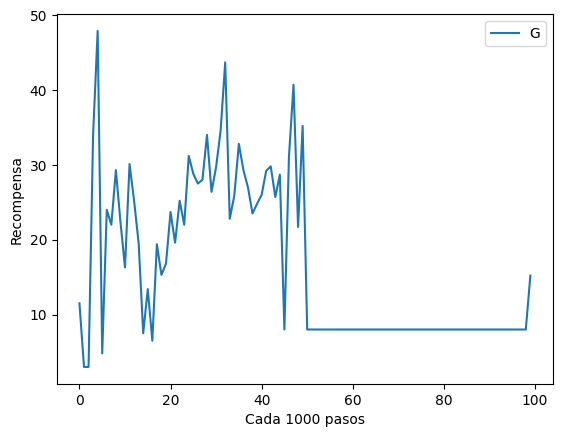

In [ ]:
plt.plot(recompensas_ent)
plt.xlabel('Cada '+ str(TEST_ITERS)+' pasos')
plt.ylabel('Recompensa')
plt.legend('Gráfico')
plt.show()